# Introduction to Knowledge Distillation 
> whith two code examples
- toc: true
- branch: master
- badges: true
- image: images/kd.png
- comments: true
- author: Sajjad Ayoubi
- categories: [implementation]

- I found [this](https://wandb.ai/authors/knowledge-distillation/reports/Distilling-Knowledge-in-Neural-Networks--VmlldzoyMjkxODk) article great for details in knowledge distillation
- Soft lables [image](https://lh4.googleusercontent.com/ZoaRoo-dWpdIx7iCmbEICmFcOPJLuVC2fc_Pau6akiBbLG6ad-IczRXgKHhnMXDuCXJbmxRU8ucPUJXH18B-cLUTvWekxqQn3cJTaybv3RGK8_5U0lxL8ZOeT6UalyelYBFpxTiL)

- Reference:
  - [Hinton et al. (2015)](https://arxiv.org/abs/1503.02531)

## My notes
- a high-quality Teacher is important
- feature map level distillation
  - `DistilBERT`
- the T and S can be anythings
  - example: T is BERT, S is LSTM
- with `aug` it has more gain
  - because augmented data has no hard label
  - with a huge T model we even don't need to have the same label `aug`
  - it's kind of semi-supervised for S
- soft labeling is really mater in `LMs`
  - I have a cute [cat, dog, pet, ...] -> dark knowledge
  - I have a cute [cat, tree, an, ...] -> one hot
- `KD` in Online learning
  - you have a small model in Server
  - with a big Model for teaching with new data
- `KD` help to regularizing `overfit` in neural networks
  - Teacher learned generalization
  - but don't use it just for this purpose

In [1]:
!nvidia-smi

Fri Apr 23 14:48:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Vision Example: Mnist Classification

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os , random

In [3]:
# Prepare the train and test dataset.
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = np.reshape(x_train, (-1, 28, 28, 1)).astype("float32")
x_test = np.reshape(x_test, (-1, 28, 28, 1)).astype("float32")

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
teacher = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Dropout(0.2),
        layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(10),
    ],
    name="teacher",
)

teacher.summary()
optim = keras.optimizers.Adam(learning_rate=1e-3)
teacher.compile(optimizer=optim,
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['acc'])

teacher.fit(x_train, y_train, epochs=8, validation_data=(x_test, y_test))

Model: "teacher"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 16)        160       
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 14, 14, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 32)          4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 32)          128       
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 32)          0   

In [5]:
def create_student():
    student = keras.Sequential(
        [
            keras.Input(shape=(28, 28, 1)),
            layers.Flatten(),
            layers.Dense(14, activation='relu'),
            layers.Dense(10),
        ],name="student")
    return student

student = create_student()
student.summary()

optim = keras.optimizers.Adam(learning_rate=1e-3)
student.compile(optimizer=optim,
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['acc'])

student.fit(x_train, y_train, epochs=6, validation_data=(x_test, y_test))

Model: "student"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 14)                10990     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                150       
Total params: 11,140
Trainable params: 11,140
Non-trainable params: 0
_________________________________________________________________
Epoch 1/6
1875/1875 [==============================] - 4s 2ms/step - loss: 5.6094 - acc: 0.1999 - val_loss: 1.7388 - val_acc: 0.3541
Epoch 2/6
1875/1875 [==============================] - 3s 2ms/step - loss: 1.5936 - acc: 0.4178 - val_loss: 1.3059 - val_acc: 0.5489
Epoch 3/6
1875/1875 [==============================] - 3s 2ms/step - loss: 1.1982 - acc: 0.5602 - val_loss: 1.0485 - va

- what is softmax temp

In [10]:
a = np.array([9., 5., 3.])

print(tf.nn.softmax(a))
print(tf.nn.softmax(a/3))
print(tf.nn.softmax(a/5))
print(tf.nn.softmax(a/10))
# T is not a HyperParams

tf.Tensor([0.97962921 0.01794253 0.00242826], shape=(3,), dtype=float64)
tf.Tensor([0.71483081 0.18842736 0.09674183], shape=(3,), dtype=float64)
tf.Tensor([0.57125779 0.25668267 0.17205954], shape=(3,), dtype=float64)
tf.Tensor([0.45062671 0.30206411 0.24730918], shape=(3,), dtype=float64)


In [11]:
class DistillLeaner(keras.Model):

    def __init__(self, student, teacher):
        super(DistillLeaner, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(self, optimizer, metrics, student_loss_fn, distill_loss_fn, alpha=0.1):
        super(DistillLeaner, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distill_loss_fn = distill_loss_fn
        self.alpha = alpha

    def train_step(self, data):
        # Unpack data
        x, y = data
        # Forward pass of teacher
        teacher_logits = self.teacher(x, training=False)
        with tf.GradientTape() as tape:
            # Forward pass of student
            student_logits = self.student(x, training=True)
            # CELoss on hard labels
            student_loss = self.student_loss_fn(y, student_logits)
            # distillation loss
            distill_loss = self.distill_loss_fn(teacher_logits, student_logits)
            # combine togather
            loss = self.alpha * student_loss + (1 - self.alpha) * distill_loss

        # Compute gradients & # Update weights
        gradients = tape.gradient(loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.student.trainable_variables))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_logits)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss, "distill_loss": distill_loss})
        return results

    def test_step(self, data):
        x, y = data
        logits = self.student(x, training=False)
        # Calculate the loss & Update the metrics.
        student_loss = self.student_loss_fn(y, logits)
        self.compiled_metrics.update_state(y, logits)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [12]:
def distill_loss_on_probs(teacher_logits, student_logits, loss_func=keras.losses.KLDivergence(), temp=3):
    teacher_probs = tf.nn.softmax(teacher_logits / temp, axis=1)
    student_logits = tf.nn.softmax(student_logits / temp, axis=1)
    loss = loss_func(teacher_probs, student_logits) * temp**2
    return loss

In [13]:
distiller = DistillLeaner(student=create_student(), teacher=teacher)

optim = keras.optimizers.Adam(learning_rate=1e-3)
distiller.compile(
    optimizer=optim, metrics=['acc'], alpha=0.5, # alpcha depends on Teacher quality
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distill_loss_fn=lambda x, y: distill_loss_on_probs(x, y, loss_func=keras.losses.KLDivergence(), temp=3),
)

distiller.fit(x_train, y_train, epochs=6, validation_data=(x_test, y_test))

Epoch 1/6
1875/1875 [==============================] - 5s 2ms/step - acc: 0.3409 - student_loss: 2.2838 - distill_loss: 11.6732 - val_acc: 0.5336 - val_student_loss: 0.9119
Epoch 2/6
1875/1875 [==============================] - 4s 2ms/step - acc: 0.6224 - student_loss: 0.9106 - distill_loss: 6.0831 - val_acc: 0.8649 - val_student_loss: 0.7081
Epoch 3/6
1875/1875 [==============================] - 4s 2ms/step - acc: 0.8674 - student_loss: 0.5287 - distill_loss: 2.5995 - val_acc: 0.8925 - val_student_loss: 0.0706
Epoch 4/6
1875/1875 [==============================] - 4s 2ms/step - acc: 0.8882 - student_loss: 0.4622 - distill_loss: 2.2731 - val_acc: 0.8834 - val_student_loss: 0.0381
Epoch 5/6
1875/1875 [==============================] - 4s 2ms/step - acc: 0.8914 - student_loss: 0.4507 - distill_loss: 2.2082 - val_acc: 0.8899 - val_student_loss: 0.1761
Epoch 6/6
1875/1875 [==============================] - 5s 2ms/step - acc: 0.8967 - student_loss: 0.4366 - distill_loss: 2.1420 - val_acc: 0

### Alpha & Temp

- good temp is range 1 to 5
- train without smooting labels
  - temp=1 regural softmax

In [15]:
distiller = DistillLeaner(student=create_student(), teacher=teacher)

optim = keras.optimizers.Adam(learning_rate=1e-3)
distiller.compile(
    optimizer=optim, metrics=['acc'], alpha=0.5, # alpcha depends on Teacher quality
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distill_loss_fn=lambda x, y: distill_loss_on_probs(x, y, loss_func=keras.losses.KLDivergence(), temp=1),
)
# the effect of TEMP
distiller.fit(x_train, y_train, epochs=6, validation_data=(x_test, y_test))

Epoch 1/6
1875/1875 [==============================] - 5s 2ms/step - acc: 0.2859 - student_loss: 2.1936 - distill_loss: 1.7353 - val_acc: 0.5280 - val_student_loss: 0.9626
Epoch 2/6
1875/1875 [==============================] - 5s 2ms/step - acc: 0.5262 - student_loss: 1.2288 - distill_loss: 1.1484 - val_acc: 0.5785 - val_student_loss: 0.8914
Epoch 3/6
1875/1875 [==============================] - 5s 2ms/step - acc: 0.6132 - student_loss: 0.9515 - distill_loss: 0.8945 - val_acc: 0.7095 - val_student_loss: 0.4716
Epoch 4/6
1875/1875 [==============================] - 4s 2ms/step - acc: 0.7398 - student_loss: 0.7168 - distill_loss: 0.6630 - val_acc: 0.8145 - val_student_loss: 0.5897
Epoch 5/6
1875/1875 [==============================] - 4s 2ms/step - acc: 0.8234 - student_loss: 0.5569 - distill_loss: 0.5128 - val_acc: 0.8512 - val_student_loss: 0.2171
Epoch 6/6
1875/1875 [==============================] - 4s 2ms/step - acc: 0.8576 - student_loss: 0.4812 - distill_loss: 0.4433 - val_acc: 0.

- train just with soft-teacher-labels

In [20]:
distiller = DistillLeaner(student=create_student(), teacher=teacher)

optim = keras.optimizers.Adam(learning_rate=1e-3)
distiller.compile(
    optimizer=optim, metrics=['acc'], alpha=0.0, # hard labels are off
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distill_loss_fn=lambda x, y: distill_loss_on_probs(x, y, loss_func=keras.losses.KLDivergence(), temp=3),
)

distiller.fit(x_train, y_train, epochs=6, validation_data=(x_test, y_test))

Epoch 1/6
1875/1875 [==============================] - 5s 2ms/step - acc: 0.3481 - student_loss: 2.7879 - distill_loss: 11.4505 - val_acc: 0.7488 - val_student_loss: 0.9149
Epoch 2/6
1875/1875 [==============================] - 4s 2ms/step - acc: 0.7764 - student_loss: 0.6838 - distill_loss: 3.5558 - val_acc: 0.8822 - val_student_loss: 0.0873
Epoch 3/6
1875/1875 [==============================] - 4s 2ms/step - acc: 0.8856 - student_loss: 0.4590 - distill_loss: 2.1813 - val_acc: 0.8943 - val_student_loss: 0.3185
Epoch 4/6
1875/1875 [==============================] - 4s 2ms/step - acc: 0.8990 - student_loss: 0.4224 - distill_loss: 1.9759 - val_acc: 0.9022 - val_student_loss: 0.0621
Epoch 5/6
1875/1875 [==============================] - 4s 2ms/step - acc: 0.9040 - student_loss: 0.4136 - distill_loss: 1.9242 - val_acc: 0.9023 - val_student_loss: 0.3587
Epoch 6/6
1875/1875 [==============================] - 5s 2ms/step - acc: 0.9042 - student_loss: 0.4031 - distill_loss: 1.8885 - val_acc: 0

- Teacher Annealing Alpha from 0 to 1
  - in earlier just look at the T then just Y

In [2]:
class TeacherAnnaling(tf.keras.callbacks.Callback):
    def __init__(self, epochs):
        super(TeacherAnnaling, self).__init__()
        self.epochs = epochs
  
    def on_epoch_end(self, epoch, logs=None):
        self.model.alpha += 1/self.epochs

In [19]:
distiller = DistillLeaner(student=create_student(), teacher=teacher)

optim = keras.optimizers.Adam(learning_rate=1e-3)
distiller.compile(
    optimizer=optim, metrics=['acc'], alpha=0.0, # alpcha depends on Teacher quality
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distill_loss_fn=lambda x, y: distill_loss_on_probs(x, y, loss_func=keras.losses.KLDivergence(), temp=3), # temps is not a hyper
)
# with CategoricalCrossentropy or MSE
ta = TeacherAnnaling(epochs=6) # [from 0.0 to 1.0 step 0.2] 
distiller.fit(x_train, y_train, epochs=6, validation_data=(x_test, y_test), callbacks=[ta])
print(distiller.alpha)

Epoch 1/6
1875/1875 [==============================] - 5s 2ms/step - acc: 0.4803 - student_loss: 3.1257 - distill_loss: 10.1510 - val_acc: 0.8081 - val_student_loss: 0.6410
Epoch 2/6
1875/1875 [==============================] - 4s 2ms/step - acc: 0.8308 - student_loss: 0.6133 - distill_loss: 3.3149 - val_acc: 0.8937 - val_student_loss: 0.0219
Epoch 3/6
1875/1875 [==============================] - 4s 2ms/step - acc: 0.8961 - student_loss: 0.4369 - distill_loss: 2.0684 - val_acc: 0.9070 - val_student_loss: 0.0320
Epoch 4/6
1875/1875 [==============================] - 5s 2ms/step - acc: 0.9041 - student_loss: 0.3980 - distill_loss: 1.8594 - val_acc: 0.9054 - val_student_loss: 0.0431
Epoch 5/6
1875/1875 [==============================] - 4s 2ms/step - acc: 0.9108 - student_loss: 0.3774 - distill_loss: 1.7609 - val_acc: 0.9092 - val_student_loss: 0.0115
Epoch 6/6
1875/1875 [==============================] - 4s 2ms/step - acc: 0.9131 - student_loss: 0.3668 - distill_loss: 1.7028 - val_acc: 0

## NLP Example: IMDB classification

In [ ]:
!pip install -q transformers
!pip install -q datasets
!pip install -q sentencepiece

     |████████████████████████████████| 2.2MB 9.0MB/s 
     |████████████████████████████████| 870kB 49.9MB/s 
     |████████████████████████████████| 3.3MB 52.5MB/s 
     |████████████████████████████████| 194kB 8.3MB/s 
     |████████████████████████████████| 245kB 16.6MB/s 
     |████████████████████████████████| 112kB 17.6MB/s 
     |████████████████████████████████| 1.2MB 8.2MB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import AlbertForSequenceClassification

In [ ]:
model_checkpoint = 'textattack/albert-base-v2-imdb'
max_length = 64
batch_size = 32
epochs = 2
lr = 3e-5

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
train, test = load_dataset('imdb', split=['train', 'test'])

In [ ]:
toknize_with_padding = lambda x: tokenizer(x['text'], truncation=True, padding=True, max_length=64) # bad model 
# prepare datasets
train_ds = train.map(toknize_with_padding, batched=True, batch_size=128).shuffle()
test_ds = test.map(toknize_with_padding, batched=True, batch_size=128).shuffle()

In [ ]:
n_sample = 1000

In [ ]:
x_train = np.array(train_ds[:n_sample]['text'])
y_train = np.array(train_ds[:n_sample]['label'])

x_test = np.array(test_ds[:n_sample]['text'])
y_test = np.array(test_ds[:n_sample]['label'])

student = make_pipeline(TfidfVectorizer(ngram_range=(1,2)), LogisticRegression()) # CountVectorizer
student.fit(x_train, y_train)
print('model trained')

y_pred = student.predict(x_test)
print(classification_report(y_test, y_pred))

model trained
              precision    recall  f1-score   support

           0       0.86      0.69      0.77       496
           1       0.75      0.89      0.81       504

    accuracy                           0.79      1000
   macro avg       0.81      0.79      0.79      1000
weighted avg       0.80      0.79      0.79      1000

CPU times: user 2.28 s, sys: 983 ms, total: 3.27 s
Wall time: 2.29 s


In [ ]:
teacher = AlbertForSequenceClassification.from_pretrained(model_checkpoint)
teacher.eval().cuda()
print('model loaded')


model loaded


In [ ]:
attention_mask = torch.tensor(test_ds['attention_mask'][:n_sample]).cuda()
input_ids = torch.tensor(test_ds['input_ids'][:n_sample]).cuda()
labels = torch.tensor(test_ds['label'][:n_sample]).cuda()

test_teacher_logits = []
batch_size = 100

with torch.no_grad():
    for i in range(0, n_sample-batch_size+1, batch_size):
        test_teacher_logits.extend(teacher.forward(input_ids=input_ids[i:i+batch_size], 
                                              attention_mask=attention_mask[i:i+batch_size], 
                                              labels=labels[i:i+batch_size])['logits'].cpu().numpy())
        
test_teacher_logits = np.array(test_teacher_logits)
y_pred = test_teacher_logits.argmax(axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.82      0.85       496
           1       0.83      0.88      0.86       504

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000



              precision    recall  f1-score   support

           0       0.90      0.85      0.87       472
           1       0.87      0.91      0.89       528

    accuracy                           0.88      1000
   macro avg       0.89      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000



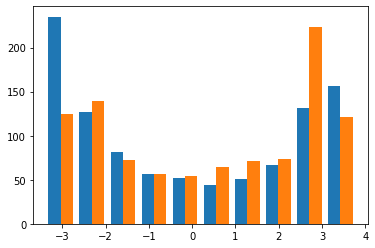

In [ ]:
attention_mask = torch.tensor(train_ds['attention_mask'][:n_sample]).cuda()
input_ids = torch.tensor(train_ds['input_ids'][:n_sample]).cuda()
labels = torch.tensor(train_ds['label'][:n_sample]).cuda()

teacher_logits = []
batch_size = 100
with torch.no_grad():
    for i in range(0, n_sample-batch_size+1, batch_size):
        teacher_logits.extend(teacher.forward(input_ids=input_ids[i:i+batch_size], 
                                              attention_mask=attention_mask[i:i+batch_size], 
                                              labels=labels[i:i+batch_size])['logits'].cpu().numpy())
        
teacher_logits = np.array(teacher_logits)
y_pred = teacher_logits.argmax(axis=1)
print(classification_report(y_train, y_pred))
plt.hist(teacher_logits);

- using logist we don't need temp

In [ ]:
student = make_pipeline(TfidfVectorizer(ngram_range=(1,2)), LinearRegression())
student.fit(x_train, teacher_logits)

y_pred = student.predict(x_test)
print(classification_report(y_test, y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.86      0.76      0.81       496
           1       0.79      0.88      0.83       504

    accuracy                           0.82      1000
   macro avg       0.83      0.82      0.82      1000
weighted avg       0.83      0.82      0.82      1000



### Overfitted Teacher

In [ ]:
from transformers import Trainer, TrainingArguments

In [ ]:
args = TrainingArguments(
    f"result",
    evaluation_strategy='epoch',
    save_steps=999999, # we don't need saving 
    learning_rate=8e-6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    )

In [ ]:
teacher = AlbertForSequenceClassification.from_pretrained(model_checkpoint)

trainer = Trainer(
    model=teacher,
    args=args,
    train_dataset=train_ds.select(range(1000)),
    eval_dataset=train_ds.select(range(1000)))

trainer.train()
teacher.eval().cuda()
print('End')

Epoch,Training Loss,Validation Loss,Runtime,Samples Per Second
1,No log,0.139151,2.438800,410.044000
2,No log,0.090243,2.437100,410.324000


End


              precision    recall  f1-score   support

           0       0.98      0.96      0.97       472
           1       0.97      0.98      0.97       528

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



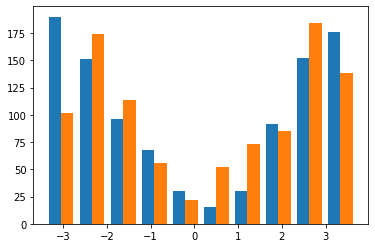

In [ ]:
attention_mask = torch.tensor(train_ds['attention_mask'][:n_sample]).cuda()
input_ids = torch.tensor(train_ds['input_ids'][:n_sample]).cuda()
labels = torch.tensor(train_ds['label'][:n_sample]).cuda()

teacher_logits = []
batch_size = 100
with torch.no_grad():
    for i in range(0, n_sample-batch_size+1, batch_size):
        teacher_logits.extend(teacher.forward(input_ids=input_ids[i:i+batch_size], 
                                              attention_mask=attention_mask[i:i+batch_size], 
                                              labels=labels[i:i+batch_size])['logits'].cpu().numpy())
        
teacher_logits = np.array(teacher_logits)
y_pred = teacher_logits.argmax(axis=1)
print(classification_report(y_train, y_pred))
plt.hist(teacher_logits);

In [ ]:
attention_mask = torch.tensor(test_ds['attention_mask'][:n_sample]).cuda()
input_ids = torch.tensor(test_ds['input_ids'][:n_sample]).cuda()
labels = torch.tensor(test_ds['label'][:n_sample]).cuda()

test_teacher_logits = []
batch_size = 100

with torch.no_grad():
    for i in range(0, n_sample-batch_size+1, batch_size):
        test_teacher_logits.extend(teacher.forward(input_ids=input_ids[i:i+batch_size],
                                              attention_mask=attention_mask[i:i+batch_size],
                                              labels=labels[i:i+batch_size])['logits'].cpu().numpy())
        
test_teacher_logits = np.array(test_teacher_logits)
y_pred = test_teacher_logits.argmax(axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       496
           1       0.85      0.83      0.84       504

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000



- even beter than teacher

In [ ]:
student = make_pipeline(TfidfVectorizer(ngram_range=(1,2)), LinearRegression())
student.fit(x_train, teacher_logits)

y_pred = student.predict(x_test)
print(classification_report(y_test, y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84       496
           1       0.84      0.86      0.85       504

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000



## More on KD
- sub-class KD
- self training with noisy student
- Well Read Students
- KD with TAs
- classwise self KD
- distillBERT 